In [1]:
import os, sys
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns 

from os.path import join 
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from IPython.display import display_html

import warnings
warnings.filterwarnings("ignore")

In [2]:
DataPath = r'D:\GitWork\titanic\data'
OutPath  = r'D:\GitWork\titanic\output'

f_abspath = join(DataPath, 'train.csv')
df_train = pd.read_csv(f_abspath)

f_abspath = join(DataPath, 'test.csv')
df_test = pd.read_csv(f_abspath)

df_data = df_train.append(df_test)
display(df_data.head())
display(df_data.describe())
display(df_data.info())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


None

In [3]:
# Show null informations
def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table','table style="display:inline;margin:10px"'), raw=True)
    return

df1 = df_train.isnull().sum().to_frame().rename(columns={0:'Train: null counts'})
df2 = df_test.isnull().sum().to_frame().rename(columns={0:'Test: null counts'})
df3 = df_data.isnull().sum().to_frame().rename(columns={0:'All: null counts'})

display_side_by_side(df1, df2, df3)

,Train: null counts
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [4]:
# For missing fare
print('Before fill missing fare:')
display(df_data.Fare.describe())

mean_fare = df_data.Fare.mean()
df_data.Fare.fillna(mean_fare, inplace=True)

print('After fill missing fare:')
display(df_data.Fare.describe())

Before fill missing fare:


count    1308.000000
mean       33.295479
std        51.758668
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64

After fill missing fare:


count    1309.000000
mean       33.295479
std        51.738879
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64

In [5]:
# For missing Embarked
print('Before fill missing Embarked:')
df = df_data.groupby('Embarked')['Embarked'].count()
display(df)

# Find the most embark port 'S'
embarked_max = df.idxmax()
print("The most embarked port is '{}'".format(embarked_max))

df_data.Embarked.fillna(embarked_max, inplace=True)

print('\nAfter fill missing Embarked:')
df = df_data.groupby('Embarked')['Embarked'].count()
display(df)

Before fill missing Embarked:


Embarked
C    270
Q    123
S    914
Name: Embarked, dtype: int64

The most embarked port is 'S'

After fill missing Embarked:


Embarked
C    270
Q    123
S    916
Name: Embarked, dtype: int64

In [6]:
# For missing ages
#
print('Before filll missing Age:')
display(df_data.Age.describe())

def fillMissingAge(df):
    col_selected = ['Fare', 'Parch', 'SibSp', 'Pclass']
    
    X1 = df[df.Age.notnull()][col_selected]
    y1 = df[df.Age.notnull()].Age
    rfr = RandomForestRegressor(random_state=0, n_estimators=1000, n_jobs=-1)
    rfr.fit(X1, y1)
    
    X2 = df[df.Age.isnull()][col_selected]
    df.loc[(df.Age.isnull()), 'Age'] = rfr.predict(X2)
    return df
    
if len(df_data[df_data.Age.isnull()]) > 0:
    df_data = fillMissingAge(df_data)

print('After filll missing Age:')
display(df_data.Age.describe())

Before filll missing Age:


count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64

After filll missing Age:


count    1309.000000
mean       29.866857
std        13.447276
min         0.170000
25%        22.000000
50%        28.183483
75%        37.000000
max        80.000000
Name: Age, dtype: float64

In [7]:
# For missing Cabin
display(df_data.Cabin.describe())

df_data.loc[ (df_data.Cabin.notnull()), 'Cabin'] = 'Yes'
df_data.loc[ (df_data.Cabin.isnull()),  'Cabin'] = 'No'

df = df_data.groupby('Cabin')['Cabin'].count()
display(df)

count             295
unique            186
top       C23 C25 C27
freq                6
Name: Cabin, dtype: object

Cabin
No     1014
Yes     295
Name: Cabin, dtype: int64

In [8]:
display(df_data.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,No,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,Yes,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,No,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,Yes,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,No,S


In [9]:
d_Sex      = pd.get_dummies(df_data.Sex,      prefix='Sex')
d_Pclass   = pd.get_dummies(df_data.Pclass,   prefix='Pclass')
d_Embarked = pd.get_dummies(df_data.Embarked, prefix='Sex')
d_Cabin    = pd.get_dummies(df_data.Cabin,    prefix='Cabin')

dataset = pd.concat([df_data, d_Sex, d_Pclass, d_Embarked, d_Cabin], axis=1)
dataset.drop(['Name', 'Sex', 'Pclass', 'Embarked', 'Cabin', 'Ticket'], axis=1, inplace=True)
display(dataset.head())

,PassengerId,Survived,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Sex_C,Sex_Q,Sex_S,Cabin_No,Cabin_Yes
0,1,0.0,22.0,1,0,7.2500,0,1,0,0,1,0,0,1,1,0
1,2,1.0,38.0,1,0,71.2833,1,0,1,0,0,1,0,0,0,1
2,3,1.0,26.0,0,0,7.9250,1,0,0,0,1,0,0,1,1,0
3,4,1.0,35.0,1,0,53.1000,1,0,1,0,0,0,0,1,0,1
4,5,0.0,35.0,0,0,8.0500,0,1,0,0,1,0,0,1,1,0


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,No,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,Yes,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,No,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,Yes,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,No,S


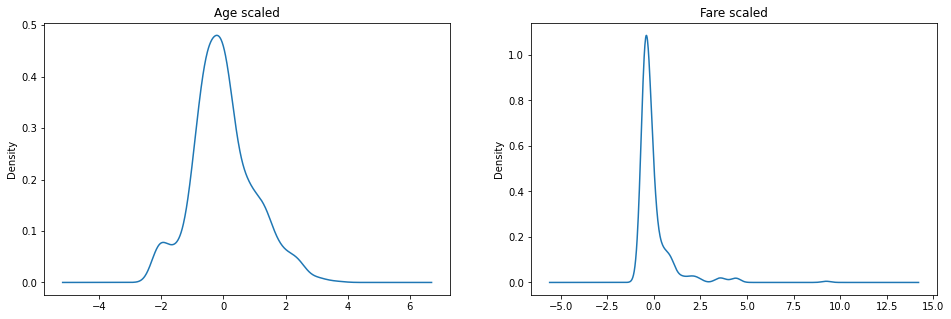

In [10]:
# Normalized Age and Fare
#
sc = StandardScaler()
dataset['Age_scaled']  = sc.fit_transform(dataset.Age.values.reshape(-1,1))
dataset['Fare_scaled'] = sc.fit_transform(dataset.Fare.values.reshape(-1,1))
display(df_data.head())

fig, axes = plt.subplots(1, 2, figsize=(16,5))

axes[0].set_title('Age scaled')
dataset.Age_scaled.plot(kind='kde', ax=axes[0])

axes[1].set_title('Fare scaled')
dataset.Fare_scaled.plot(kind='kde', ax=axes[1])

plt.show()

In [14]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score

ds_data = dataset.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
display(ds_data.head())

len_train = len(df_train)
ds_train = ds_data[:len_train]

col_selected = ds_train.columns.drop('Survived')
trainX = ds_train[col_selected]
trainY = ds_train.Survived

lr = linear_model.LogisticRegression(C=1.0, penalty='l1', solver='liblinear', tol=1e-6)
lr.fit(trainX, trainY)

coef_df = pd.DataFrame({"columns": col_selected, "coef": list(lr.coef_.T)})
display(coef_df)

print(cross_val_score(lr, trainX, trainY, cv=5))

,Survived,SibSp,Parch,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Sex_C,Sex_Q,Sex_S,Cabin_No,Cabin_Yes,Age_scaled,Fare_scaled
0,0.0,1,0,0,1,0,0,1,0,0,1,1,0,-0.585239,-0.503595
1,1.0,1,0,1,0,1,0,0,1,0,0,0,1,0.605048,0.734503
2,1.0,0,0,1,0,0,0,1,0,0,1,1,0,-0.287667,-0.490544
3,1.0,1,0,1,0,1,0,0,0,0,1,0,1,0.381870,0.382925
4,0.0,0,0,0,1,0,0,1,0,0,1,1,0,0.381870,-0.488127


,columns,coef
0,SibSp,[-0.35130297816602596]
1,Parch,[-0.10744233706980395]
2,Sex_female,[1.9512467167378262]
3,Sex_male,[-0.6919421166495533]
4,Pclass_1,[0.38796598266949395]
5,Pclass_2,[0.0]
6,Pclass_3,[-1.2221213566225357]
7,Sex_C,[0.0]
8,Sex_Q,[0.0]
9,Sex_S,[-0.3963215933195021]


[0.81564246 0.80337079 0.80337079 0.78651685 0.81460674]


In [18]:
from sklearn.model_selection import train_test_split

ds_data = dataset.filter(regex='PassengerId|Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
display(ds_data.head())

len_train = len(df_train)
ds_tran = ds_data[:len_train]
ds_test = ds_data[len_train:] 

# Split train data to train : valid = 7 : 3
train_set, valid_set = train_test_split(ds_tran, test_size=0.3, random_state=42)

# 生成模型
lr = linear_model.LogisticRegression(C=1.0, penalty='l1', solver='liblinear', tol=1e-6)

col_selected = train_set.columns.drop(['PassengerId','Survived'])
trainX = train_set[col_selected]
trainY = train_set.Survived
lr.fit(trainX, trainY)

# 对cross validation数据进行预测
validX = valid_set[col_selected]
preds = lr.predict(validX)

bad_cases = dataset.loc[
    dataset.PassengerId.isin(
        valid_set[preds != valid_set.Survived]['PassengerId'].values
)]

num_pred = len(valid_set)
num_bads = len(bad_cases)
print('\Total: {}, ㄉnum_pred, num_bads, round((num_bads/num_pred), 3))
display(bad_cases)

,PassengerId,Survived,SibSp,Parch,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Sex_C,Sex_Q,Sex_S,Cabin_No,Cabin_Yes,Age_scaled,Fare_scaled
0,1,0.0,1,0,0,1,0,0,1,0,0,1,1,0,-0.585239,-0.503595
1,2,1.0,1,0,1,0,1,0,0,1,0,0,0,1,0.605048,0.734503
2,3,1.0,0,0,1,0,0,0,1,0,0,1,1,0,-0.287667,-0.490544
3,4,1.0,1,0,1,0,1,0,0,0,0,1,0,1,0.381870,0.382925
4,5,0.0,0,0,0,1,0,0,1,0,0,1,1,0,0.381870,-0.488127


268 50 0.187


,PassengerId,Survived,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Sex_C,Sex_Q,Sex_S,Cabin_No,Cabin_Yes,Age_scaled,Fare_scaled
23,24,1.0,28.000000,0,0,35.5000,0,1,1,0,0,0,0,1,0,1,-0.138881,0.042625
25,26,1.0,38.000000,1,5,31.3875,1,0,0,0,1,0,0,1,1,0,0.605048,-0.036891
49,50,0.0,18.000000,1,0,17.8000,1,0,0,0,1,0,0,1,1,0,-0.882810,-0.299608
55,56,1.0,44.087543,0,0,35.5000,0,1,1,0,0,0,0,1,0,1,1.057918,0.042625
65,66,1.0,8.273891,1,1,15.2458,0,1,0,0,1,1,0,0,1,0,-1.606364,-0.348994
78,79,1.0,0.830000,0,2,29.0000,0,1,0,1,0,0,0,1,1,0,-2.160137,-0.083054
81,82,1.0,29.000000,0,0,9.5000,0,1,0,0,1,0,0,1,1,0,-0.064488,-0.460091
118,119,0.0,24.000000,0,1,247.5208,0,1,1,0,0,1,0,0,0,1,-0.436453,4.142092
139,140,0.0,24.000000,0,0,79.2000,0,1,1,0,0,1,0,0,0,1,-0.436453,0.887574
165,166,1.0,9.000000,0,2,20.5250,0,1,0,0,1,0,0,1,1,0,-1.552347,-0.246920
